In [76]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('sample.csv')

In [77]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Customer_ID     100 non-null    int64 
 1   Age             100 non-null    int64 
 2   Annual_Income   100 non-null    int64 
 3   Gender          100 non-null    object
 4   City            100 non-null    object
 5   Education       100 non-null    object
 6   Spending_Score  100 non-null    int64 
dtypes: int64(4), object(3)
memory usage: 5.6+ KB


In [78]:
df.describe()

,Customer_ID,Age,Annual_Income,Spending_Score
count,100.000000,100.000000,100.000000,100.000000
mean,50.500000,29.550000,50962.810000,52.590000
std,29.011492,9.404893,25987.775173,22.628352
min,1.000000,18.000000,21218.000000,11.000000
25%,25.750000,22.000000,31011.750000,32.750000
50%,50.500000,27.000000,42625.000000,49.500000
75%,75.250000,33.000000,64289.000000,72.250000
max,100.000000,57.000000,118148.000000,97.000000


In [79]:
df.sample(10)

,Customer_ID,Age,Annual_Income,Gender,City,Education,Spending_Score
67,68,27,37115,Male,B,ITE,49
48,49,22,25659,Female,A,ITE,47
43,44,27,33004,Female,A,ITE,39
72,73,32,110108,Female,A,Master,78
88,89,37,57453,Male,A,Bachelor,70
81,82,20,34362,Female,B,Secondary School,11
42,43,25,65342,Female,B,Bachelor,55
70,71,19,34207,Male,B,Secondary School,23
73,74,23,33352,Female,A,ITE,23
57,58,29,38922,Female,B,ITE,26


In [80]:
df = df.dropna()
df = df.drop(columns = ['Customer_ID'])
features = df.columns.tolist()
X = df[features]

In [81]:
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()

# Must define order for ordinal features
education_order = ['Secondary School', 'ITE', 'Diploma', 'Bachelor', 'Master']
ordinal_features = ['Education']

categorical_features = [col for col in categorical_features if col not in ordinal_features]

print("Numeric features:", numeric_features)
print("Categorical features:", categorical_features)
print("Ordinal features:", ordinal_features)

Numeric features: ['Age', 'Annual_Income', 'Spending_Score']
Categorical features: ['Gender', 'City']
Ordinal features: ['Education']


In [82]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', drop = 'first'), categorical_features),
        ('ord', OrdinalEncoder(categories=[education_order]), ordinal_features)
    ])

In [83]:
wcss = []

# Preprocess data first (to feed into K-Means)
X_processed = preprocessor.fit_transform(X)

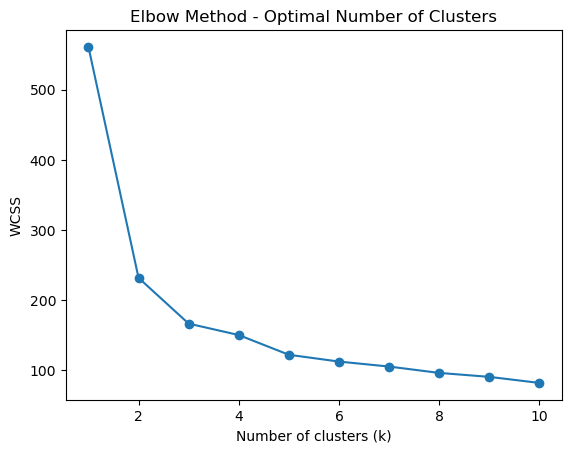

In [84]:
# Try k values from 1 to 10
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_processed)
    wcss.append(kmeans.inertia_)

# Plot Elbow Method
plt.plot(range(1, 11), wcss, marker='o')
plt.title('Elbow Method - Optimal Number of Clusters')
plt.xlabel('Number of clusters (k)')
plt.ylabel('WCSS')
plt.show()

In [85]:
from sklearn.metrics import silhouette_score

silhouette_scores = []
K_range = range(2, 11)  # start from 2 (since silhouette needs ≥ 2 clusters)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_processed)
    score = silhouette_score(X_processed, labels)
    silhouette_scores.append(score)
    print(f"k={k}, silhouette score={score:.3f}")

k=2, silhouette score=0.473
k=3, silhouette score=0.379
k=4, silhouette score=0.388
k=5, silhouette score=0.299
k=6, silhouette score=0.267
k=7, silhouette score=0.288
k=8, silhouette score=0.231
k=9, silhouette score=0.221
k=10, silhouette score=0.225


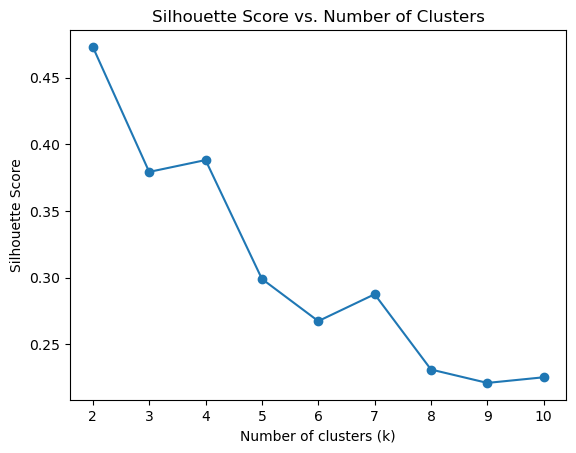

In [86]:
plt.plot(K_range, silhouette_scores, marker='o')
plt.title('Silhouette Score vs. Number of Clusters')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.show()

In [87]:
best_k = K_range[np.argmax(silhouette_scores)]
print("Optimal number of clusters:", best_k)

Optimal number of clusters: 2


In [88]:
"""
To auto detect optimal no of clusters
"""

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('pca', PCA(n_components=2)),
    ('kmeans', KMeans(n_clusters=best_k, random_state=42))
])

pipeline.fit(X)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Age', 'Annual_Income',
                                                   'Spending_Score']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['Gender', 'City']),
                                                 ('ord',
                                                  OrdinalEncoder(categories=[['Secondary '
                                                                              'School',
                                                                              'ITE',
                                                                              'Diploma',
                                                                              'Bachelor',
                                                                              'Master']]),
                                                  ['Education'])])),
                ('pca', PCA(n_components=2)),
                ('kmeans', KMeans(n_clusters=2, random_state=42))])

In [89]:
# Get transformed data (for visualization)
pca_data = pipeline.named_steps['pca'].transform(
    pipeline.named_steps['preprocessor'].transform(X)
)

# Add results back to DataFrame
df['PC1'] = pca_data[:, 0]
df['PC2'] = pca_data[:, 1]
df['Cluster'] = pipeline.named_steps['kmeans'].labels_

In [90]:
df

,Age,Annual_Income,Gender,City,Education,Spending_Score,PC1,PC2,Cluster
0,36,62662,Female,C,Bachelor,58,1.208231,-0.399770,0
1,37,73067,Male,B,Master,71,2.333046,0.478618,0
2,22,32454,Female,A,Diploma,59,-0.565792,-0.917208,1
3,53,118148,Male,B,Master,72,3.825766,1.715617,0
4,41,70965,Male,A,Master,96,3.011317,-0.146217,0
...,...,...,...,...,...,...,...,...,...
95,22,49711,Female,A,Diploma,32,-0.810266,-0.435801,1
96,47,94584,Male,B,Master,79,3.300028,1.109215,0
97,25,25569,Male,B,ITE,22,-1.950887,0.860945,1
98,27,27733,Female,B,ITE,43,-1.438312,0.335165,1


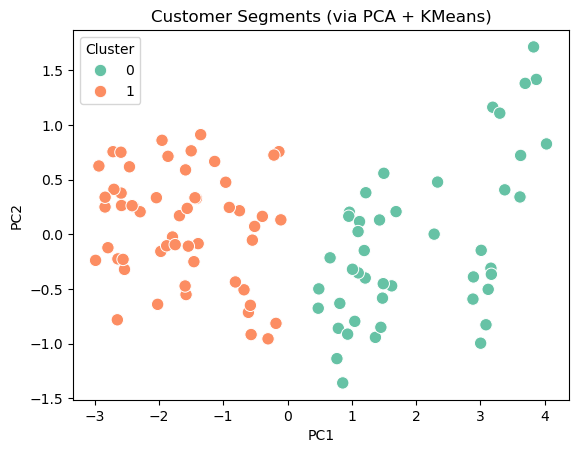

In [91]:
sns.scatterplot(
    x='PC1', y='PC2',
    hue='Cluster',
    data=df,
    palette='Set2',
    s=80
)
plt.title('Customer Segments (via PCA + KMeans)')
plt.show()

In [92]:
df['Cluster'] = pipeline.named_steps['kmeans'].labels_

numeric_summary = df.groupby('Cluster')[['Age', 'Annual_Income', 'Spending_Score']].mean()

gender_summary = (
    df.groupby(['Cluster', 'Gender']).size()
      .unstack(fill_value=0)           # Columns = Male, Female
      .apply(lambda x: x / x.sum() * 100)  # Convert to %
      .round(2)
)

location_summary = (
    df.groupby(['Cluster', 'City']).size()
      .unstack(fill_value=0)
      .apply(lambda x: x / x.sum() * 100)
      .round(2)
)

education_summary = (
    df.groupby(['Cluster', 'Education']).size()
      .unstack(fill_value=0)
      .apply(lambda x: x / x.sum() * 100)
      .round(2)
)

cluster_summary = numeric_summary.join(gender_summary).join(location_summary).join(education_summary)
cluster_summary



,Age,Annual_Income,Spending_Score,Female,Male,A,B,C,Bachelor,Diploma,ITE,Master,Secondary School
Cluster,,,,,,,,,,,,,
0,36.666667,72650.577778,73.977778,40.35,51.16,52.63,32.43,52.0,100.0,0.0,0.0,100.0,0.0
1,23.727273,33218.272727,35.090909,59.65,48.84,47.37,67.57,48.0,0.0,100.0,100.0,0.0,100.0


/var/folders/jn/k87rrm694dq263mh4gqmfd080000gn/T/ipykernel_17393/2622621405.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cluster_summary.index, y=cluster_summary['Age'], palette='Set2', ax=axes[0,0])
/var/folders/jn/k87rrm694dq263mh4gqmfd080000gn/T/ipykernel_17393/2622621405.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cluster_summary.index, y=cluster_summary['Annual_Income'], palette='Set2', ax=axes[0,1])


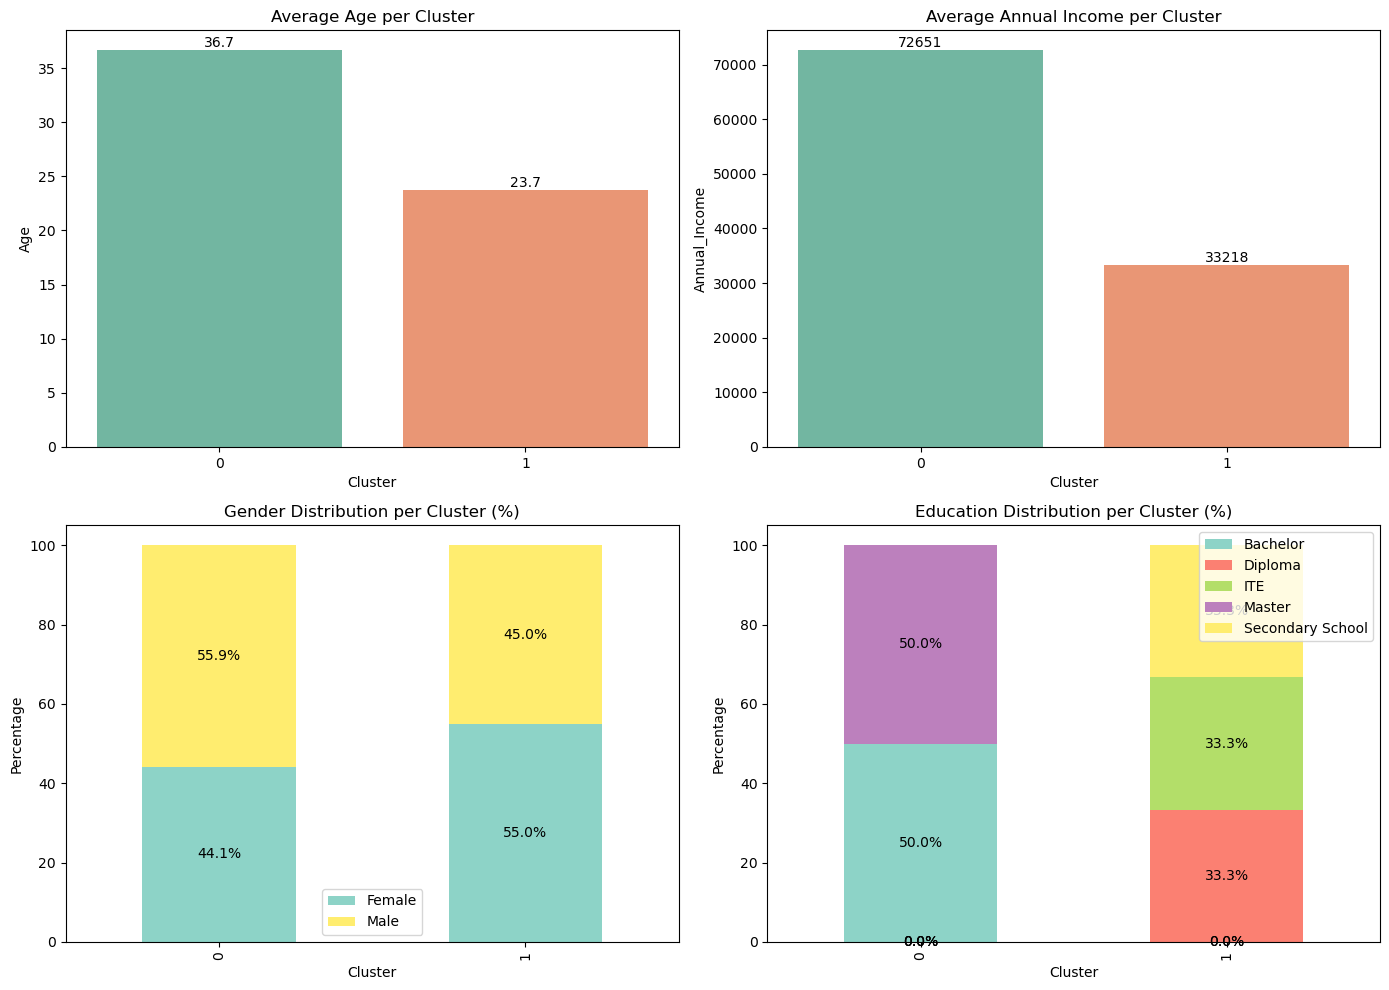

In [103]:
fig, axes = plt.subplots(2, 2, figsize=(14,10))

# --- Numeric: Age ---
sns.barplot(x=cluster_summary.index, y=cluster_summary['Age'], palette='Set2', ax=axes[0,0])
axes[0,0].set_title('Average Age per Cluster')
for p in axes[0,0].patches:
    axes[0,0].annotate(f'{p.get_height():.1f}', 
                       (p.get_x() + p.get_width()/2., p.get_height()),
                       ha='center', va='bottom')

# --- Numeric: Annual_Income ---
sns.barplot(x=cluster_summary.index, y=cluster_summary['Annual_Income'], palette='Set2', ax=axes[0,1])
axes[0,1].set_title('Average Annual Income per Cluster')
for p in axes[0,1].patches:
    axes[0,1].annotate(f'{p.get_height():.0f}', 
                       (p.get_x() + p.get_width()/2., p.get_height()),
                       ha='center', va='bottom')

# --- Categorical: Gender (normalized to 100%) ---
gender_cols = [col for col in cluster_summary.columns if col in df['Gender'].unique()]
gender_data = cluster_summary[gender_cols].div(cluster_summary[gender_cols].sum(axis=1), axis=0) * 100

gender_ax = gender_data.plot(kind='bar', stacked=True, colormap='Set3', ax=axes[1,0])
axes[1,0].set_title('Gender Distribution per Cluster (%)')
axes[1,0].set_ylabel('Percentage')
for container in gender_ax.containers:
    gender_ax.bar_label(container, fmt='%.1f%%', label_type='center')

# --- Categorical: Education (normalized to 100%) ---
edu_cols = [col for col in cluster_summary.columns if col in df['Education'].unique()]
edu_data = cluster_summary[edu_cols].div(cluster_summary[edu_cols].sum(axis=1), axis=0) * 100

edu_ax = edu_data.plot(kind='bar', stacked=True, colormap='Set3', ax=axes[1,1])
axes[1,1].set_title('Education Distribution per Cluster (%)')
axes[1,1].set_ylabel('Percentage')
for container in edu_ax.containers:
    edu_ax.bar_label(container, fmt='%.1f%%', label_type='center')

plt.tight_layout()
plt.show()
